This notebook implements the uncertainity estimate in deeplearning model using dropout probability.

This is based on the paper based below.

# Concrete Dropout.

https://arxiv.org/pdf/1705.07832.pdf

In [1]:
#importing required packages
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Dense,Wrapper, InputSpec, InputLayer,concatenate
import tensorflow.keras.backend as K

In [2]:
# This is a wrapper function from tensorflow used to create takes a layer and helps to create a new layer
class ConcreteDropout(Wrapper):
   
    def __init__(self,layer,weight_regularizer = 1e-6 , dropout_regularizer = 1e-5, init_min = 0.1, init_max = 0.1, is_mc_dropout=True, **kwargs):
        assert 'kernel_regulaizer' not in kwargs
        super(ConcreteDropout, self).__init__(layer, **kwargs)
        self.weight_regularizer = weight_regularizer
        self.dropout_regularizer = dropout_regularizer
        self.supports_masking = True
        self.is_mc_dropout = is_mc_dropout
        self.p_logit = None
        self.p = None
        self.init_min = (np.log(init_min) - np.log(1. - init_min))
        self.init_max = (np.log(init_max) - np.log(1. - init_max))
    
    def build(self,input_shape = None):
        self.input_spec = InputSpec(shape=input_shape)       
        if not self.layer.built:
            self.layer.build(input_shape)
            self.layer.built = True
                
        super(ConcreteDropout,self).build()
                
        self.p_logit = self.layer.add_weight(name = 'p_logit',shape =(1,),
                                         initializer = tf.keras.initializers.RandomUniform(self.init_min,self.init_max),trainable=True)

        self.p = K.sigmoid(self.p_logit[0])   
        
        assert len(input_shape) == 2
        input_dim = int(np.prod(input_shape[-1]))
        
        weight = self.layer.kernel
        
        kernel_regularizer = self.weight_regularizer * K.sum(K.square(weight)) / (1. - self.p)
        dropout_regularizer = self.p * K.log(self.p)
        dropout_regularizer += (1. - self.p) * K.log(1. - self.p)
        dropout_regularizer *= self.dropout_regularizer * input_dim
        regularizer = K.sum(kernel_regularizer + dropout_regularizer)
        self.layer.add_loss(regularizer)
        
        
    def compute_output_shape(self,input_shape):
        return self.layer.compute_output_shape(input_shape)
    
    def concrete_dropout(self,x):
        
        eps = 1e-7
        temp = 0.1
        
        unif_noise = K.random_uniform( shape = K.shape(x))
        drop_prob = (K.log(self.p + eps) - K.log(1. - self.p + eps) 
                    + K.log(unif_noise + eps) - K.log(1. - unif_noise + eps))
        
        drop_prob =K.sigmoid(drop_prob / temp)
        
        random_tensor = 1. - drop_prob
        retain_prob = 1. - self.p
        x *= random_tensor
        x /= retain_prob
        
        return x
    
    def call(self, inputs, training=None):
        if self.is_mc_dropout:
            return self.layer.call(self.concrete_dropout(inputs))
        else:
            def relaxed_dropped_inputs():
                return self.layer.call(self.concrete_dropout(inputs))
            return K.in_train_phase(relaxed_dropped_inputs,
                                    self.layer.call(inputs),
                                    training=training)

Processing the input data and splitting up

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [4]:
path = 'C:/Users/UI931791/OneDrive - RWE/Project- Load Analyisis/Data/2018_v112-neustadt-dosse-10min.csv'

df = pd.read_csv(path)

In [5]:
x_scaler = StandardScaler()
y_scaler = StandardScaler()

In [6]:
#specifying the required features for the model and the output headers
x_headers = ['BladeLoadA_max','BladeLoadA_sd','WindSpeed_max','WindSpeed_sd','PowerActive_max','PowerActive_sd',
            'NacelleAccX_max','NacelleAccY_max','NacelleAccX_sd','NacelleAccY_sd','ThetaA_max','ThetaA_sd']
y_headers = ['MYTB_del_m4','MZTB_del_m4','MYTM_del_m4','MZTM_del_m4','MYTT_del_m4','MZTT_del_m4']

# y_headers = ['MYTB_del_m4']

In [7]:
#Standardscling the input and outputs
x_norm = x_scaler.fit_transform(df[x_headers])
y_norm = y_scaler.fit_transform(df[y_headers])

In [8]:
X_train, X_test, Y_train, Y_test = train_test_split(x_norm, y_norm,test_size=0.4,shuffle=True)

X_shape = X_train.shape[-1]
Y_shape = Y_train.shape[-1]

Fitting the model

In [9]:
from tensorflow.keras import Model
from tensorflow.keras import Input
from tensorflow.keras.optimizers import Adam

#Function for training the model
def fit_model(batchsize , epoch ,lr ,X , Y):
    opt = Adam(learning_rate = lr) 
    N = X.shape[0] #This N values is number of data points, in concrete dropout the uncertainity reduces with increase in N value
    wd = 1**2. / N
    dd = 2. / N
    
    #First layer input
    inp = Input(shape = (X.shape[-1],))
    x = inp
    
    #Hidden layers
    for i in range(3):
        x = ConcreteDropout(Dense(100,activation='relu'),weight_regularizer = wd, dropout_regularizer= dd)(x)
    
    #output layer mean and log_var
    mean = ConcreteDropout(Dense(Y.shape[-1]), weight_regularizer=wd, dropout_regularizer=dd)(x)
    log_var = ConcreteDropout(Dense(Y.shape[-1]), weight_regularizer=wd, dropout_regularizer=dd)(x)
    out = concatenate([mean, log_var])
    model = Model(inp, out) 
    print(model.summary())
    
    
    #loss function used for training the model
    def heteroscedastic_loss(true,pred):
        mean = pred[:, :Y_shape]
        log_var = pred[:, Y_shape:]
        precision = K.exp(-log_var)
        
        return K.sum(precision * (true - mean) ** 2. + log_var, -1)
    
    model.compile(optimizer = opt,loss=heteroscedastic_loss)
    assert len(model.layers[1].trainable_weights) == 3
    assert len(model.losses) == 5
    
    hist = model.fit(X,Y,batch_size = batchsize , verbose = 'auto', epochs = epoch)
    loss = hist.history['loss'][-1]
    
    return model, -0.5*loss
    
    

In [10]:
from scipy.stats import norm

#This function is used to take samples from the model
def predictive_samples(model,test,no_samples=500):
    
    
    pred_samples = np.array([model.predict(test) for _ in range(no_samples)])
    
    samples = pred_samples[ : , : , :Y_shape]
    log_var = np.mean(pred_samples[ : , : , Y_shape:],0)
    

    
    return samples, log_var
    

In [11]:
#This function takes samples and throws uncertainity and its lower and upper band

def prediction_interval(samples,log_var,ci=0.95):
    #PPF - per point probability, ci - confidence interval
    q = norm.ppf(0.5*(1 + ci))
    
    epistemic_ucn = (np.var(samples,0).mean(0))**0.5
    aletroic_ucn = (np.exp(log_var).mean(0))**0.5
    pred = samples.mean(0)
    
    total_ucn = (aletroic_ucn **2  + epistemic_ucn **2 ) **0.5
    
    lwr = pred - q * total_ucn
    upr = pred + q * total_ucn
    
    return pred,total_ucn, lwr,upr

In [89]:
#This function calculates the PICP and MPIW taking actual(Y_true) and CI

def cal_PICP_MPIW(model,test,y_true,no_samples=500,ci=0.95):
    pred_samples = np.array([model.predict(test) for _ in range(no_samples)])
    
    samples = pred_samples[ : , : , :Y_shape]
    log_var = pred_samples[ : , : , Y_shape:]
    
    q = norm.ppf(0.5*(1 + ci))

    epistemic_ucn = (np.var(samples,0))**0.5
    aletroic_ucn = (np.exp(log_var))**0.5
    pred = samples
    
    total_ucn = (aletroic_ucn **2  + epistemic_ucn **2 ) **0.5
    
    lwr = pred - q * total_ucn
    upr = pred + q * total_ucn
    
    lwr = y_scaler.inverse_transform(lwr)
    upr = y_scaler.inverse_transform(upr)


    K_u = upr > y_true
    K_l = lwr < y_true


    PICP = np.mean(K_u * K_l)
    MPIW=np.round(np.mean(upr - lwr),3)
    
    return PICP,MPIW


In [12]:
#hyper parameters used for training
batchsize = 50
epoch = 500
lr=0.001
model,ELBO = fit_model(batchsize,epoch,lr ,X_train,Y_train)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 12)]         0                                            
__________________________________________________________________________________________________
concrete_dropout (ConcreteDropo (None, 100)          1301        input_1[0][0]                    
__________________________________________________________________________________________________
concrete_dropout_1 (ConcreteDro (None, 100)          10101       concrete_dropout[0][0]           
__________________________________________________________________________________________________
concrete_dropout_2 (ConcreteDro (None, 100)          10101       concrete_dropout_1[0][0]         
______________________________________________________________________________________________

In [101]:
samples, log_var = predictive_samples(model,X_test,no_samples=500)


In [92]:
PICP,MPIW = cal_PICP_MPIW(model,X_test,y_true,no_samples=500,ci=0.95)

In [97]:
print("PICP:" , PICP)
print("MPIW:" , MPIW)

PICP: 0.9710134897693136
MPIW: 4557.802


In [102]:
pred,total_ucn, lwr,upr = prediction_interval(samples,log_var,ci=0.95)

In [103]:
pred = y_scaler.inverse_transform(pred)
x_true = x_scaler.inverse_transform(X_test)
y_true = y_scaler.inverse_transform(Y_test)

lwr = y_scaler.inverse_transform(lwr)
upr = y_scaler.inverse_transform(upr)

In [20]:
results = pd.DataFrame()
for _ in range(len(y_headers)):
    results['pred_'+y_headers[_]] = pred[:,_]
    results['actual_'+y_headers[_]] = y_true[:,_]
    results['lwr_'+y_headers[_]] = lwr[:,_]
    results['upr_'+y_headers[_]] = upr[:,_]
    
results['X'] = x_true[:,2]   


In [17]:
results = results.sort_values(by = 'X')

In [18]:
def plot_graph(X,y_true,pred,lwr,upr,ax,title):
    
    ax.scatter(X,y_true,color = 'blue',label='actual',linewidth=.001)
    ax.scatter(X,pred,color = 'red',label='predicted',linewidth=.001)
    ax.fill_between(X, lwr, upr,label='uncertainity',alpha=0.2)
    ax.set_title('{} - r2 {:.4f}'.format(title,r2_score(y_true,pred)))
    ax.set_xlabel('WindSpeed_max')
    ax.set_ylabel('DEL')
    ax.grid()
    ax.legend();

In [19]:
results

,pred_MYTB_del_m4,actual_MYTB_del_m4,lwr_MYTB_del_m4,upr_MYTB_del_m4,pred_MZTB_del_m4,actual_MZTB_del_m4,lwr_MZTB_del_m4,upr_MZTB_del_m4,pred_MYTM_del_m4,actual_MYTM_del_m4,...,upr_MZTM_del_m4,pred_MYTT_del_m4,actual_MYTT_del_m4,lwr_MYTT_del_m4,upr_MYTT_del_m4,pred_MZTT_del_m4,actual_MZTT_del_m4,lwr_MZTT_del_m4,upr_MZTT_del_m4,X
9114,1496.586060,1204.897287,-1459.223022,4452.395508,2533.646729,2575.433214,-4677.228027,9744.521484,564.615417,475.654428,...,4244.377441,157.432999,149.745771,-147.153976,462.020020,590.711548,700.748641,-461.835785,1643.259155,3.683
5383,3889.651367,3389.632196,933.841919,6845.460449,8245.679688,11647.659020,1034.805054,15456.555664,1509.945312,1248.859918,...,6222.102051,373.006195,365.917590,68.419212,677.593201,1930.889648,2174.783639,878.342163,2983.437256,3.692
6078,1542.777954,1096.418256,-1413.031616,4498.586914,2752.951416,2621.084227,-4457.923340,9963.826172,579.736511,412.199596,...,4331.529785,165.763870,113.939316,-138.823044,470.350891,636.359009,720.003757,-416.188568,1688.906738,3.694
7444,1212.211060,1263.754531,-1743.598022,4168.020020,1396.164429,1239.190784,-5814.710449,8607.038086,460.599518,514.821276,...,3752.820068,111.602745,136.757429,-192.984299,416.189728,443.986969,472.241534,-608.560913,1496.534546,3.733
7783,1099.358032,1204.166789,-1856.451538,4055.166992,1231.469116,1296.357136,-5979.405762,8442.343750,414.445953,481.691503,...,3697.004639,98.831200,93.634988,-205.755905,403.418182,396.993561,488.191999,-655.554077,1449.541138,3.760
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9936,44041.355469,43491.175830,41085.542969,46997.164062,102326.578125,106308.693800,95115.703125,109537.453125,18346.931641,17985.497100,...,47519.496094,2908.998779,3190.545295,2604.411865,3213.585938,9615.950195,9677.282383,8563.402344,10668.498047,22.417
9219,43396.601562,48123.857150,40440.792969,46352.410156,67659.250000,54623.716630,60448.371094,74870.125000,18100.554688,20032.174310,...,32457.251953,2769.810547,3412.791394,2465.223633,3074.397705,8200.067383,7422.345463,7147.519043,9252.615234,22.912
9934,59425.234375,62728.799740,56469.425781,62381.039062,86573.984375,76138.222600,79363.109375,93784.859375,24903.509766,25994.796890,...,41117.722656,3390.684082,3621.643093,3086.096924,3695.270996,9743.211914,10840.447900,8690.665039,10795.759766,23.055
9305,60172.367188,65670.985410,57216.558594,63128.171875,87314.320312,82903.413700,80103.445312,94525.195312,25211.708984,27125.413210,...,41432.988281,3485.548828,3909.574789,3180.961670,3790.135742,9834.366211,8676.497568,8781.818359,10886.913086,23.699


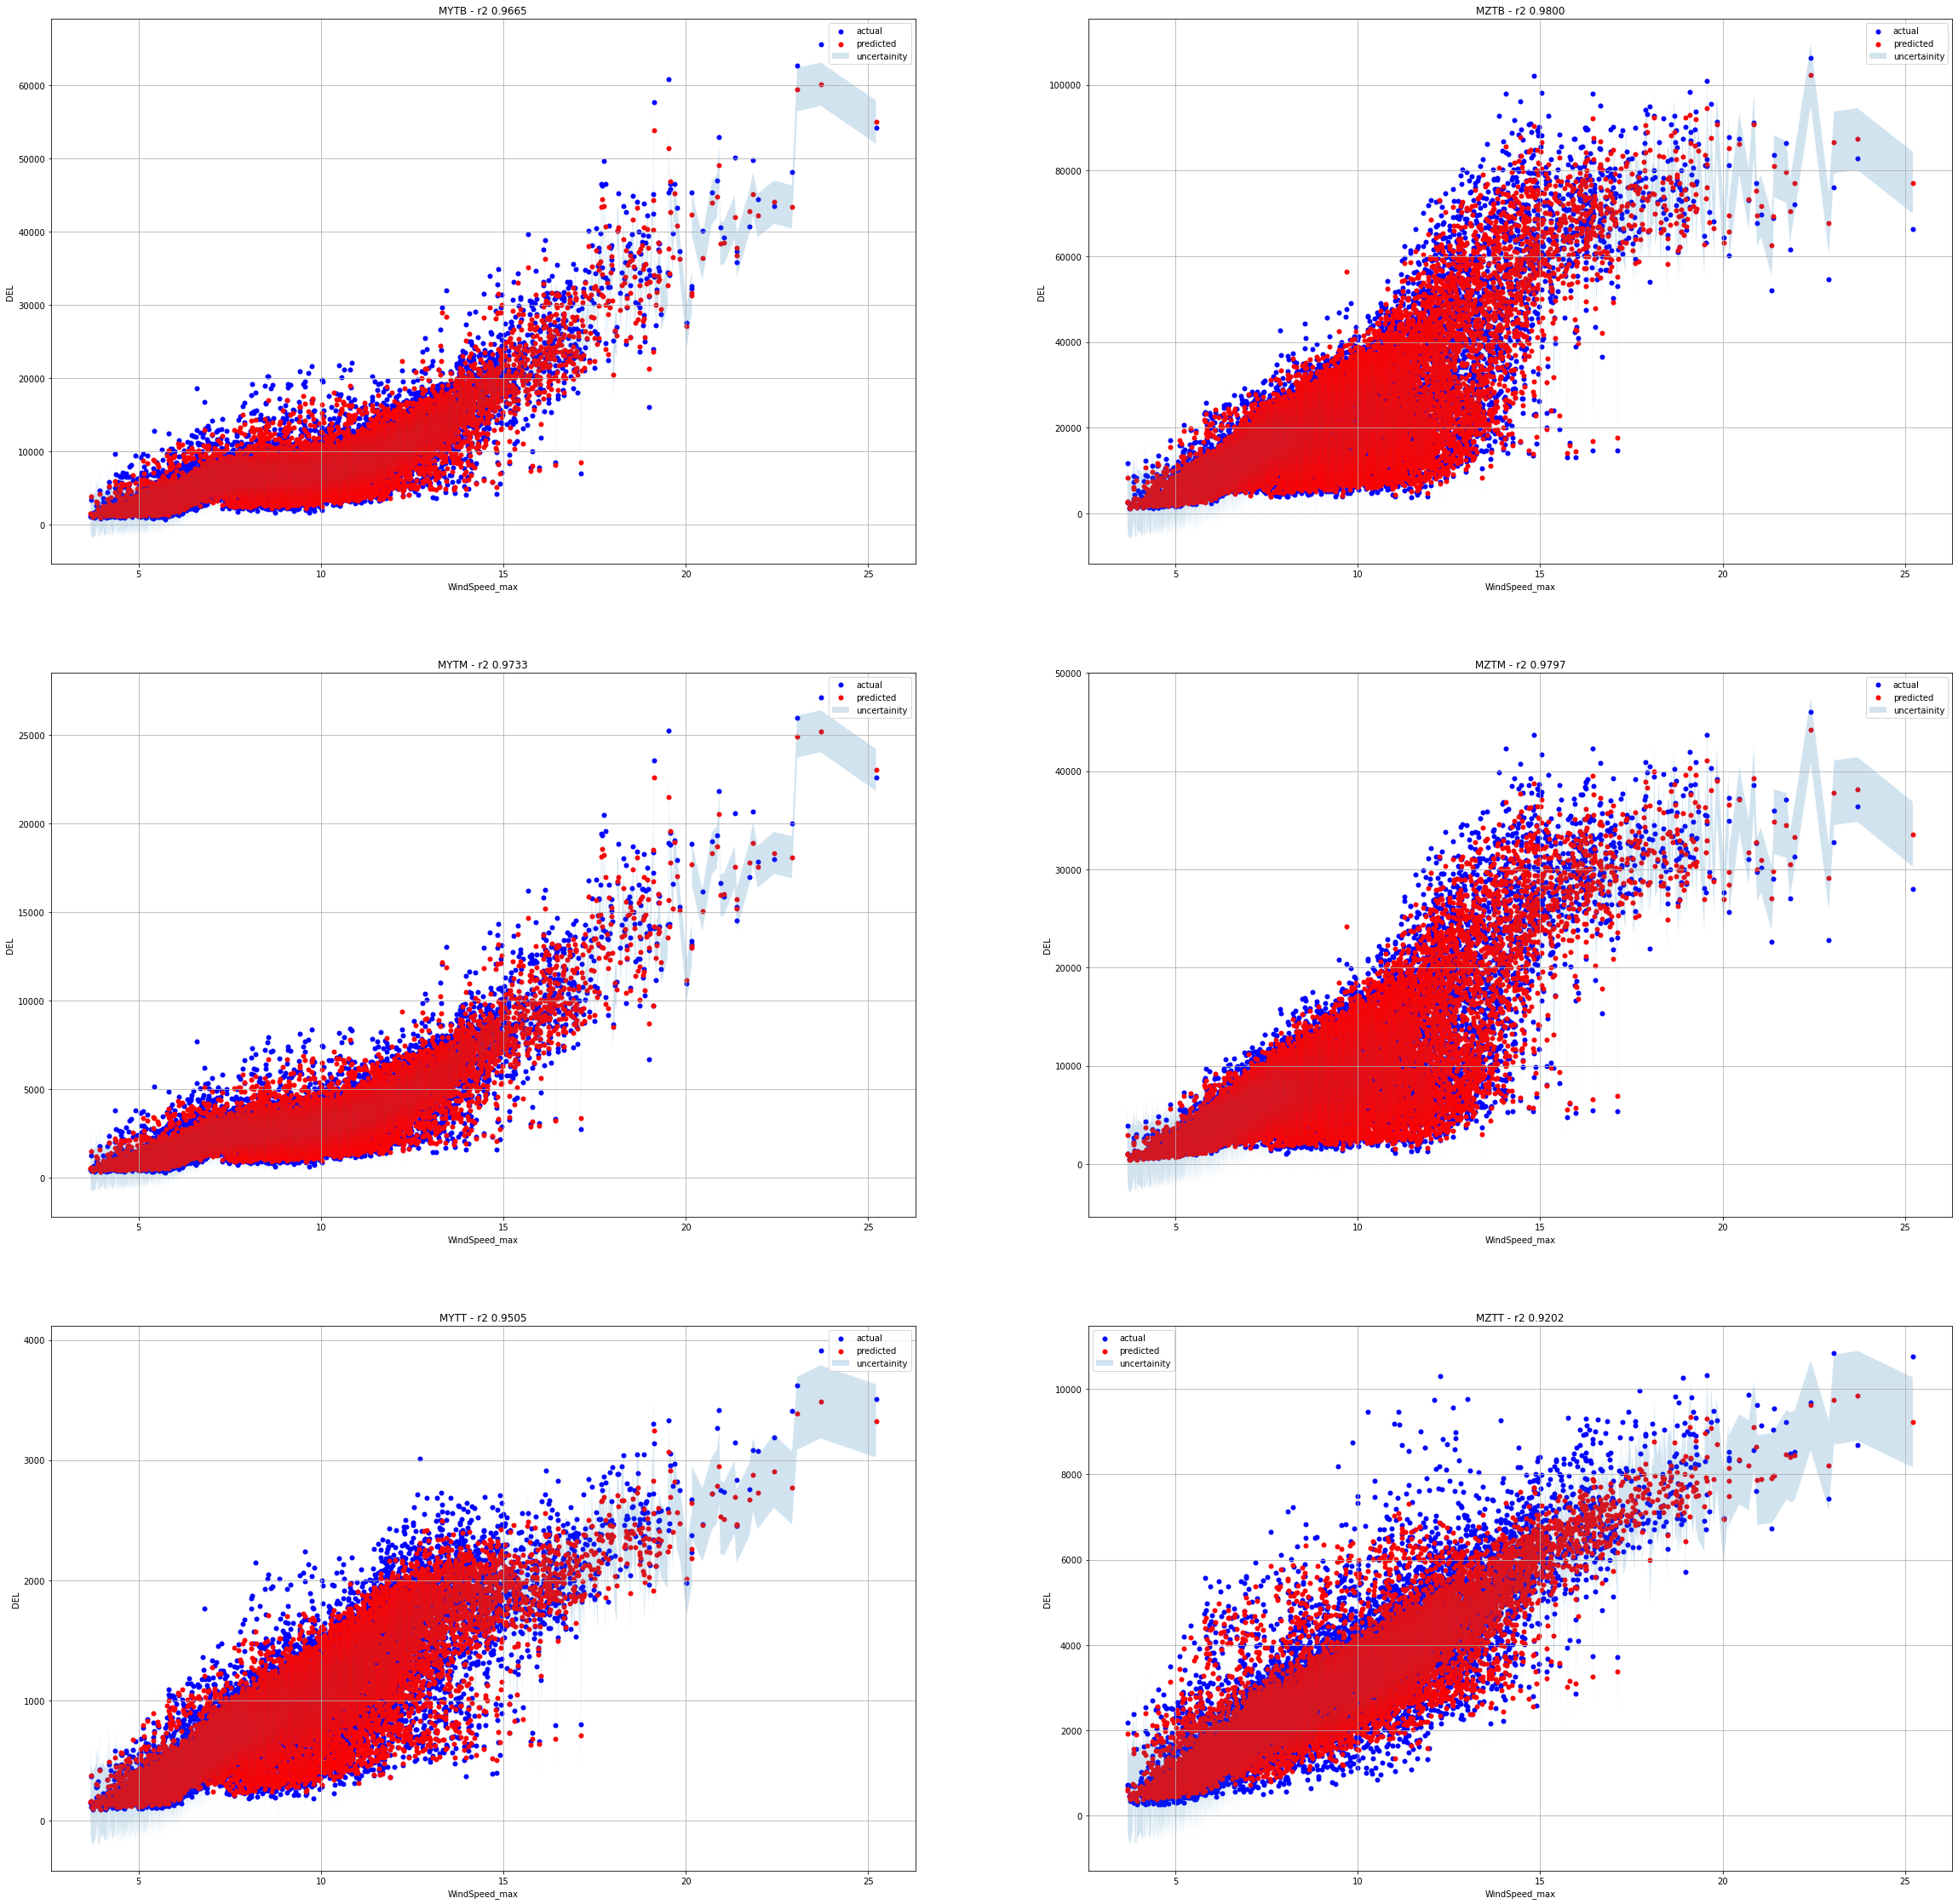

In [20]:
from sklearn.metrics import r2_score

results = results.sort_values(by = 'X')
fig, ax = plt.subplots(3,2,figsize=(40,40))
plot_graph(results['X'],results['actual_MYTB_del_m4'],results['pred_MYTB_del_m4'],results['lwr_MYTB_del_m4'],results['upr_MYTB_del_m4'],ax[0,0],title='MYTB')
plot_graph(results['X'],results['actual_MZTB_del_m4'],results['pred_MZTB_del_m4'],results['lwr_MZTB_del_m4'],results['upr_MZTB_del_m4'],ax[0,1],title='MZTB')
plot_graph(results['X'],results['actual_MYTM_del_m4'],results['pred_MYTM_del_m4'],results['lwr_MYTM_del_m4'],results['upr_MYTM_del_m4'],ax[1,0],title='MYTM')
plot_graph(results['X'],results['actual_MZTM_del_m4'],results['pred_MZTM_del_m4'],results['lwr_MZTM_del_m4'],results['upr_MZTM_del_m4'],ax[1,1],title='MZTM')
plot_graph(results['X'],results['actual_MYTT_del_m4'],results['pred_MYTT_del_m4'],results['lwr_MYTT_del_m4'],results['upr_MYTT_del_m4'],ax[2,0],title='MYTT')
plot_graph(results['X'],results['actual_MZTT_del_m4'],results['pred_MZTT_del_m4'],results['lwr_MZTT_del_m4'],results['upr_MZTT_del_m4'],ax[2,1],title='MZTT')

In [21]:
def woehler_sum(x, m):
    return (np.sum(x**m))**(1/m)

In [22]:
accumalated_load = np.apply_along_axis(woehler_sum,1,samples,m=4)

In [23]:
accumalated_load = y_scaler.inverse_transform(accumalated_load)

In [24]:
measured_load = np.apply_along_axis(woehler_sum,0,Y_test,m=4)

In [25]:
measured_load = y_scaler.inverse_transform(measured_load)

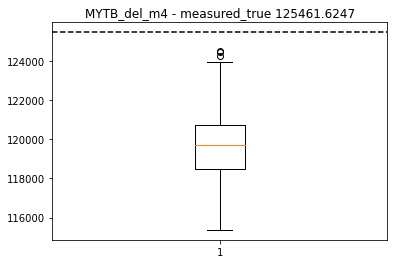

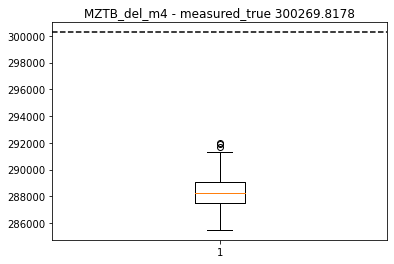

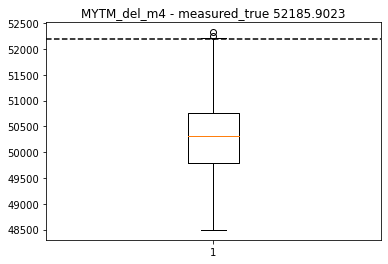

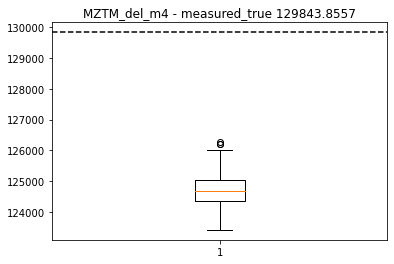

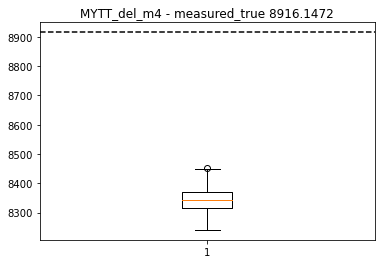

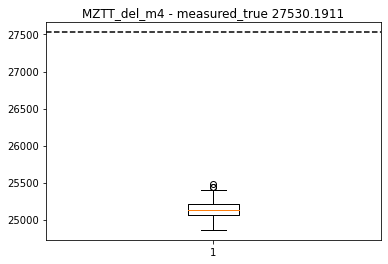

In [26]:
import seaborn as sns
for i in range(len(y_headers)):
    plt.boxplot(accumalated_load[:,i])
    plt.axhline(measured_load[i], ls='--', c='black')
    plt.title('{} - measured_true {:.4f}'.format(y_headers[i],measured_load[i]))
    plt.show()